# MVP Engenharia de Dados

**Nome:** Viviane Mendes Matos

**Matrícula:** 4052025000007

**Dataset:** [Disney+ Dataset from Kaggle](https://raw.githubusercontent.com/vivianemattos/mvp-vmm-analise-dados-boas-praticas/refs/heads/main/disney_plus_titles.csv)

# 1. Objetivo
O objetivo deste MVP é responder algumas questões importantes sobre o conteúdo da plataforma Disney+ conhecida mundialmente e amplamente consumida por pessoas de todas as idades.

O Disney+ é uma das plataformas de streaming de vídeo e mídia mais populares. Com cerca de 1450 filmes e séries disponíveis em sua plataforma (dados de meados de 2021), a plataforma contava com mais de 116 milhões de assinantes em todo o mundo. Este conjunto de dados tabulares lista todos os filmes e séries disponíveis no Disney+, incluindo detalhes como elenco, diretores, classificação indicativa, ano de lançamento, duração, etc.

Estas questões principais são:
1) Qual é o tempo médio entre o lançamento e a entrada no catálogo Disney+ para filmes?
2) Como foi a evolução da diversidade de gêneros únicos no catálogo ao longo do tempo considerando o ano de adição na plataforma?
3) Quais gêneros de conteúdo são mais frequentes no Disney+?

# 2. Coleta de Dados
A fim de responder às hipóteses levantadas, foi selecionado o dataset 'Disney+ Movies and TV Shows' disponível no Kaggle (link: https://www.kaggle.com/datasets/shivamb/disney-movies-and-tv-shows ) e hospedado no GitHub no link (https://github.com/vivianemattos/mvp-vmm-engenharia-de-dados/blob/main/data/disney_plus_titles_w43.csv).

Foi realizado download do dataset e carregado via python no notebook.



#3. Arquitetura
Para este trabalho foi selecionada a arquitetura Medallion implementada no Databricks Free Edition. 

A arquitetura Medallion no Databricks é um padrão de organização de dados (muito usado com Delta Lake) que estrutura o pipeline em camadas para evoluir os dados de “brutos” para “prontos para consumo”, com qualidade, rastreabilidade e governança ao longo do caminho. Em vez de “um ETL gigante”, você tem etapas claras e auditáveis.

- **Camada Bronze (ingest)**: Entrada de dados, onde são capturados e preservados os dados originais com pouquíssima ou nenhuma transformação
- **Camada Silver (clean)**: Dados limpos, padronizados e consistentes
- **Camada Gold (analytics)**: Camada final para consumo, dados modelados para o negócio e prontos para serem consumidos em ferramentas de BI ou relatórios

# 4. Modelagem

## 4.1 Modelagem no esquema estrela (star schema)

Foi feita a modelagem em esquema estrela para refletir a necessidade de resposta às hipóteses levantadas como objetivo deste MVP de forma a otimizar as informações para geração de relatórios e dashboards.

A escolha da tabela fato neste modelo considerou o caráter _factless_ do cenário analisado, no qual o principal interesse não está em medidas transacionais explícitas, mas na ocorrência de um evento: a entrada de um título no catálogo da plataforma Disney+. Dado que o dataset não contém métricas quantitativas nativas associadas a esse evento, a tabela fato foi definida para representar o registro da adição do título ao catálogo, com granularidade de um título por data de inclusão, servindo como ponto central de ligação entre as dimensões. Essa abordagem permite realizar contagens, segmentações e análises temporais por meio das chaves dimensionais, além de suportar métricas derivadas, como o intervalo entre lançamento e inclusão (lag_days), mantendo o modelo simples, consistente e alinhado às boas práticas de modelagem dimensional para eventos sem medidas transacionais diretas.

![](https://dbc-3492ebdc-148e.cloud.databricks.com/ajax-api/2.0/workspace-files/Users/viviane.mattos%40gmail.com/mvp-vmm-engenharia-de-dados/notebooks/MER%20StarSchema%20Disney%2B.png?o=1875325151292961)

![](https://github.com/vivianemattos/mvp-vmm-engenharia-de-dados/blob/main/notebooks/MER%20StarSchema%20Disney%2B.png)


## 4.2 Catálogo de Dados

Para o catálogo de dados foi gerado um arquivo PDF disponível no GitHUb no link
[Catálogo de Dados](https://github.com/vivianemattos/mvp-vmm-engenharia-de-dados/blob/main/notebooks/Catalogo_Dados.pdf)

## 4.3 Linhagem dos Dados

Os dados utilizados neste MVP têm origem em um dataset público do Kaggle, intitulado Disney+ Movies and TV Shows, disponibilizado em formato CSV único (flat file). O dataset contém informações sobre o catálogo da plataforma Disney+, incluindo tipo de conteúdo, ano de lançamento, data de adição ao catálogo, classificação indicativa e gêneros. Essa fonte constitui o ponto inicial da linhagem dos dados e foi utilizada sem alterações em sua estrutura original na etapa de ingestão.

A implementação do processo de ETL foi realizada no ambiente Databricks, seguindo a arquitetura Medallion. Na camada Bronze, os dados foram carregados de forma bruta, preservando integralmente o conteúdo do arquivo CSV para fins de rastreabilidade, auditoria e reprocessamento. Na camada Silver, foram aplicadas limpezas e transformações simples, como tratamento de valores nulos, padronização de tipos de dados e normalização de campos multivalorados (por exemplo, gêneros), preparando os dados para uso analítico.

Na camada Gold, os dados consolidados da Silver foram organizados em um modelo dimensional em esquema estrela, com tabelas fato e dimensões, orientadas ao consumo analítico. Nessa etapa foram criadas métricas derivadas, como o intervalo entre o lançamento do título e sua entrada no catálogo (lag_days), permitindo responder às perguntas analíticas do MVP. A separação em camadas garante clareza na linhagem, governança dos dados e aderência a boas práticas de engenharia de dados em ambientes Lakehouse.


Linhagem dos Dados
![](https://dbc-3492ebdc-148e.cloud.databricks.com/ajax-api/2.0/workspace-files/Users/viviane.mattos%40gmail.com/mvp-vmm-engenharia-de-dados/notebooks/Linhagem%20de%20Dados%20-%20MVP.png?o=1875325151292961)
![](https://github.com/vivianemattos/mvp-vmm-engenharia-de-dados/blob/main/notebooks/Linhagem%20de%20Dados%20-%20MVP.pngh)

#5. Carga de Dados
Neste bloco temos a ingestão de dados direto da fonte com leitura e persistência dos dados na tabela Delta.


## 5.1 Camada de Preparação / Setup

In [0]:
#CAMADA DE PREPARAÇÃO
## Import de Bibliotecas
## Criação e Estruturas de Schemas

#--IMPORTANDO BIBLIOTECAS--

%pip install requests

import pandas as pd
from pyspark.sql.functions import *
from pyspark.sql.types import (StructType, StructField, StringType, DateType, IntegerType)
#import dlt
from pyspark.sql.functions import col, trim, to_date, regexp_extract, when, split, explode
import requests
from pyspark.sql import functions as F


#--CAMADA BRONZE--
#criacao do schema bronze
spark.sql(""" CREATE SCHEMA IF NOT EXISTS bronze """)

#definicao do esquema bronze personalizado
bronze = StructType([
    StructField("show_id", StringType(), True), 
    StructField("type", StringType(), True),         
    StructField("director", StringType(), True),
    StructField("cast", StringType(), True), 
    StructField("country", StringType(), True), 
    StructField("date_added", DateType(), True),
    StructField("release_year", IntegerType(), True),
    StructField("rating", StringType(), True),
    StructField("duration", StringType(), True),
    StructField("listed_in", StringType(), True),
    StructField("description", StringType(), True)
])

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


##5.2 Camada Bronze (ingest)
Realizar a ingestão do dataset Disney+ Movies and TV Shows a partir de um arquivo CSV versionado no GitHub.

Nesta camada, os dados são carregados **exatamente como recebidos**, sem transformações semânticas, garantindo rastreabilidade e reprodutibilidade.

O arquivo é lido diretamente do repositório GitHub, garantindo que qualquer execução futura utilize exatamente a mesma versão do dataset.

In [0]:
# ## Leitura do Arquivo CSV a partir do GitHub e Criação de Tabela Bronze para Persistência dos Dados

#--INGESTÃO DOS DADOS BRUTOS NA CAMADA BRONZE

# Leitura do arquivo csv fonte para um dataframe pandas e spark
import pandas as pd
from pyspark.sql.functions import *

url = "https://raw.githubusercontent.com/vivianemattos/mvp-vmm-engenharia-de-dados/main/data/disney_plus_titles_w43.csv"
pd_df_bronze_raw = pd.read_csv(url)

#conversão para spark
spark_df_bronze_raw = spark.createDataFrame(pd_df_bronze_raw)

#criação da tabela bronze para persistência dos dados
spark_df_bronze_raw.write.format("delta").mode("overwrite").saveAsTable("bronze.disney_titles_raw")

#criação de view temporária para ser referenciada em outros notebooks
spark_df_bronze_raw.createOrReplaceTempView("temp_df_bronze")

#exibição dos 5 primeiros registros da tabela bronze
#display(spark_df_bronze_raw)
print("Exibição dos 5 primeiros registros da tabela bronze")
display(spark_df_bronze_raw.limit(5))

#exibição dos 5 últimos registros da tabela bronze
print("Exibição dos 5 últimos registros da tabela bronze")
display(spark_df_bronze_raw.orderBy(desc("show_id")).limit(5))

Exibição dos 5 primeiros registros da tabela bronze


show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
s1,Movie,Duck the Halls: A Mickey Mouse Christmas Special,"Alonso Ramirez Ramos, Dave Wasson","Chris Diamantopoulos, Tony Anselmo, Tress MacNeille, Bill Farmer, Russi Taylor, Corey Burton",null,"November 26, 2021",2016,TV-G,23 min,"Animation, Family",Join Mickey and the gang as they duck the halls!
s2,Movie,Ernest Saves Christmas,John Cherry,"Jim Varney, Noelle Parker, Douglas Seale",null,"November 26, 2021",1988,PG,91 min,Comedy,Santa Claus passes his magic bag to a new St. Nic.
s3,Movie,Ice Age: A Mammoth Christmas,Karen Disher,"Raymond Albert Romano, John Leguizamo, Denis Leary, Queen Latifah",United States,"November 26, 2021",2011,TV-G,23 min,"Animation, Comedy, Family",Sid the Sloth is on Santa's naughty list.
s4,Movie,The Queen Family Singalong,Hamish Hamilton,"Darren Criss, Adam Lambert, Derek Hough, Alexander Jean, Fall Out Boy, Jimmie Allen",null,"November 26, 2021",2021,TV-PG,41 min,Musical,"This is real life, not just fantasy!"
s5,TV Show,The Beatles: Get Back,null,"John Lennon, Paul McCartney, George Harrison, Ringo Starr",null,"November 25, 2021",2021,null,1 Season,"Docuseries, Historical, Music",A three-part documentary from Peter Jackson capturing a moment in music history with The Beatles.


Exibição dos 5 últimos registros da tabela bronze


show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
s999,Movie,Lady and the Tramp,Charlie Bean,"Tessa Thompson, Justin Theroux, Sam Elliott, Ashley Jensen, Janelle Monáe, Kiersey Clemons",United States,"November 12, 2019",2019,PG,111 min,"Action-Adventure, Comedy, Family",A house dog and a stray embark on an adventure and come to understand the value of home.
s998,TV Show,Lab Rats,null,"Billy Unger, Spencer Boldman, Kelli Berglund, Tyrel Williams, Hal Sparks",United States,"November 12, 2019",2011,TV-Y7,4 Seasons,"Action-Adventure, Comedy, Coming of Age",Leo discovers a secret underground lab with three experiments.
s997,Movie,La Luna,Enrico Casarosa,"Tony Fucile, Krista Sheffler, Phil Sheridan",United States,"November 12, 2019",2012,G,7 min,"Animation, Coming of Age, Family",A peculiar story about a young boy coming of age.
s996,Movie,Kronk's New Groove,"Elliot Bour, Saul Blinkoff","Patrick Warburton, Tracey Ullman, Eartha Kitt, David Spade, John Goodman, Wendie Malick",United States,"November 12, 2019",2005,G,78 min,"Animation, Comedy, Coming of Age",Kronk cooks up a get-rich-quick scheme to impress his Dad.
s995,Movie,Knick Knack Theatrical Short,John Lasseter,null,null,"November 12, 2019",2003,G,4 min,"Animation, Family, Kids",A snowman longs to break out of his snow globe.


### Validações Iniciais

Nesta etapa são realizadas validações básicas para garantir:
- leitura correta do arquivo
- quantidade esperada de registros


In [0]:
%sql
SELECT 
    COUNT(*) AS total_registros
FROM bronze.disney_titles_raw;

total_registros
1450


## 5.3 Camada Silver (cleaning: Tratamento e Padronização)

Transformar os dados da camada Bronze em uma base canônica (Silver), com:

- padronização de tipos
- normalização de atributos
- normalização relacional de campos multivalorados (N:N), garantindo melhor qualidade analítica

### Fonte
- Entrada: `bronze.disney_titles_raw`
- Saídas:
  - `silver.disney_titles_clean` (tabela canônica)
  - tabelas normalizadas:
    - `silver.title_genres`
    - `silver.title_countries`
    - `silver.title_directors`
    - `silver.title_cast`

### Principais Transformações
- Conversão de `date_added` para tipo data
- Normalização de duração (minutos / temporadas)
- Padronização de campos categóricos

Exibindo a análise de nulos e vazios dos atributos alvo da análise antes da transformação

In [0]:
%sql
SELECT
  COUNT(*)                                  AS total_rows,
  SUM(CASE WHEN title IS NULL THEN 1 ELSE 0 END)        AS null_title_count,
  SUM(CASE WHEN date_added IS NULL THEN 1 ELSE 0 END)        AS null_date_added,
  SUM(CASE WHEN release_year IS NULL THEN 1 ELSE 0 END)        AS null_release_year,
  SUM(CASE WHEN rating IS NULL THEN 1 ELSE 0 END)      AS null_rating,
  SUM(CASE WHEN type IS NULL THEN 1 ELSE 0 END)     AS null_type
FROM bronze.disney_titles_raw;

total_rows,null_title_count,null_date_added,null_release_year,null_rating,null_type
1450,0,3,0,3,0


In [0]:
from pyspark.sql import functions as F

df = spark.table("bronze.disney_titles_raw")

print("1. Iniciando transformações de campos com padronizações leves")
# Padronizações leves e canônicas
df_silver = (
    df
    # trims básicos
    .withColumn("show_id", F.trim(F.col("show_id")))
    .withColumn("type", F.trim(F.col("type")))
    .withColumn("title", F.trim(F.col("title")))
    .withColumn("rating", F.trim(F.col("rating")))
    .withColumn("listed_in", F.trim(F.col("listed_in")))
    .withColumn("country", F.trim(F.col("country")))
    .withColumn("director", F.trim(F.col("director")))
    .withColumn("cast", F.trim(F.col("cast")))
    .withColumn("description", F.trim(F.col("description")))
    
    # parse de data
    .withColumn("date_added_dt", F.expr("try_to_date(date_added)"))
    
    # normalização de duração (num/unidade)
    .withColumn("duration_num", F.regexp_extract("duration", r"(\d+)", 1).cast("int"))
    .withColumn(
        "duration_unit",
        F.when(F.col("duration").contains("min"), F.lit("min"))
         .when(F.col("duration").contains("Season"), F.lit("season"))
         .otherwise(F.lit(None))
    )
    .withColumn("duration_minutes", F.when(F.col("duration_unit") == "min", F.col("duration_num")))
    .withColumn("seasons", F.when(F.col("duration_unit") == "season", F.col("duration_num")))
    
    # tipagem do ano de lançamento
    .withColumn("release_year_int", F.col("release_year").cast("int"))
    
    # normalização de strings vazias para null (boa prática)
    .withColumn("director", F.nullif(F.col("director"), F.lit("")))
    .withColumn("cast", F.nullif(F.col("cast"), F.lit("")))
    .withColumn("country", F.nullif(F.col("country"), F.lit("")))
    .withColumn("rating", F.nullif(F.col("rating"), F.lit("")))
)

print("Transformações de campos com padronizações leves concluídas (Remoção de vazios, normalização de duração, conversão de data, tipo do ano de lançamento e normalização de strings vazias para null).")

# Remover duplicidades por show_id (se existirem) mantendo a primeira ocorrência
print("2. Removendo duplicadas no campo show_id")
df_silver = df_silver.dropDuplicates(["show_id"])
print("Duplicadas no campo show_id removidas.")

# Remover linhas com null para atributos alvo da análise
print('3. Removendo linhas com null para atributos alvo da análise')
required_cols = ["title", "date_added", "release_year", "rating", "type"]
df_silver = (
    df_silver
    # remove nulos
    .dropna(subset=required_cols)
    # remove strings vazias ou apenas espaços
    .filter(
        (F.trim(F.col("title")) != "") &
        (F.trim(F.col("rating")) != "")
    )
)
print("Dados com null para atributos alvo da análise removidos.")

# Persistência canônica Silver
print("4. Persistindo dados canônicos camada Silver em tabela Delta")
(df_silver
 .write
 .format("delta")
 .mode("overwrite")
 .saveAsTable("silver.disney_titles_clean"))
print("Tabela Delta salva")

print("5. Exibindo 5 primeiras linhas da tabela Delta - Camada Silver")
display(df_silver.limit(5))

1. Iniciando transformações de campos com padronizações leves
Transformações de campos com padronizações leves concluídas (Remoção de vazios, normalização de duração, conversão de data, tipo do ano de lançamento e normalização de strings vazias para null).
2. Removendo duplicadas no campo show_id
Duplicadas no campo show_id removidas.
3. Removendo linhas com null para atributos alvo da análise
Dados com null para atributos alvo da análise removidos.
4. Persistindo dados canônicos camada Silver em tabela Delta
Tabela Delta salva
5. Exibindo 5 primeiras linhas da tabela Delta - Camada Silver


show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,date_added_dt,duration_num,duration_unit,duration_minutes,seasons,release_year_int
s537,TV Show,Disney Prop Culture,null,Daniel Lanigan,United States,"May 1, 2020",2020,TV-PG,1 Season,Docuseries,"Collector Dan Lanigan reunites iconic Disney movie props with filmmakers, actors, and crew.",null,1,season,null,1,2020
s722,Movie,Alice in Wonderland,"Clyde Geronimi, Hamilton Luske, Wilfred Jackson","Ed Wynn, Richard Haydn, Sterling Holloway, Jerry Colonna, Verna Felton, Pat O'Malley",United States,"November 12, 2019",1951,G,79 min,"Action-Adventure, Animation, Family",Join Alice as she chases the White Rabbit into a topsy-turvy world.,null,79,min,79,null,1951
s47,Movie,Santa Buddies: The Legend of Santa Paws,Robert Vince,"Christopher Lloyd, Danny Woodburn, Craig Anton, Michael Teigen, Ben Giroux, Paul Rae","United States, Canada","November 5, 2021",2009,G,93 min,"Comedy, Fantasy, Kids","The Buddies remind Santa Paws' feisty son, Puppy Paws, about the true meaning of Christmas.",null,93,min,93,null,2009
s266,TV Show,Star Wars Vintage: Clone Wars 2D Micro-Series,null,"Mat Lucas, James Arnold Taylor, Tom Kane, Grey DeLisle, Corey Burton, André Sogliuzzo",null,"April 2, 2021",2021,TV-Y7-FV,1 Season,Series,"Enjoy this thrilling, Emmy® Award-winning animated series that continues the Star Wars story.",null,1,season,null,1,2021
s715,Movie,A Goofy Movie,Kevin Lima,"Bill Farmer, Jason Marsden, Jim Cummings, Kellie Martin, Rob Paulsen, Wallace Shawn","United States, Australia, France, Canada","November 12, 2019",1995,G,81 min,"Action-Adventure, Animation, Comedy",Goofy and Max hit the road and get up to their floppy ears in misadventure.,null,81,min,81,null,1995


Exibindo os atributos alvo após limpeza

In [0]:
%sql
SELECT
  COUNT(*)                                  AS total_rows,
  SUM(CASE WHEN title IS NULL THEN 1 ELSE 0 END)        AS null_title_count,
  SUM(CASE WHEN date_added IS NULL THEN 1 ELSE 0 END)        AS null_date_added,
  SUM(CASE WHEN release_year IS NULL THEN 1 ELSE 0 END)        AS null_release_year,
  SUM(CASE WHEN rating IS NULL THEN 1 ELSE 0 END)      AS null_rating,
  SUM(CASE WHEN type IS NULL THEN 1 ELSE 0 END)     AS null_type
FROM silver.disney_titles_clean;

total_rows,null_title_count,null_date_added,null_release_year,null_rating,null_type
1444,0,0,0,0,0


### Validação da quantidade de linhas da camada Silver persistida

Demonstrando que a camada bronze possuía 1450 linhas e após o saneamento de 6 linhas que apresentaram inconsistências, a camada silver saneada ficou com 1444 linhas válidas. 

In [0]:
%sql
SELECT COUNT (*) FROM silver.disney_titles_clean

COUNT(*)
1444


### Normalização de Campos Multivalorados (N:N)

O dataset contém campos com múltiplos valores em uma única coluna (separados por vírgula),
o que prejudica análises e modelagem estrela.

Nesta etapa, normalizamos para tabelas auxiliares do tipo:
- show_id + valor_normalizado

Campos normalizados:
- `listed_in` → gêneros (title_genres)
- `country` → países (title_countries)
- `director` → diretores (title_directors)
- `cast` → elenco (title_cast)

In [0]:
from pyspark.sql import DataFrame

print("6. Normalizando campos multivalorados")

def normalize_multivalue(df_base: DataFrame, id_col: str, src_col: str, out_col: str, out_table: str):
    """
    Cria uma tabela normalizada (N:N) a partir de uma coluna multivalorada separada por vírgula.
    - Remove espaços extras
    - Remove valores vazios
    - Remove duplicidades show_id + valor
    """
    normalized = (
        df_base
        .select(F.col(id_col).alias(id_col), F.col(src_col).alias(src_col))
        .filter(F.col(src_col).isNotNull())
        .withColumn(out_col, F.explode(F.split(F.col(src_col), r",\s*")))
        .withColumn(out_col, F.trim(F.col(out_col)))
        .filter(F.col(out_col).isNotNull() & (F.col(out_col) != ""))
        .select(id_col, out_col)
        .dropDuplicates([id_col, out_col])
    )
    
    (normalized
     .write
     .format("delta")
     .mode("overwrite")
     .saveAsTable(out_table))
    
    return normalized



6. Normalizando campos multivalorados


In [0]:
base = spark.table("silver.disney_titles_clean")

print("- Normalização do campo 'listed_in' (gêneros)")
# Gêneros: listed_in
normalize_multivalue(
    df_base=base,
    id_col="show_id",
    src_col="listed_in",
    out_col="genre",
    out_table="silver.title_genres"
)

print("- Normalização do campo 'country'")
# Países: country
normalize_multivalue(
    df_base=base,
    id_col="show_id",
    src_col="country",
    out_col="country_name",
    out_table="silver.title_countries"
)

print("- Normalização do campo 'director'")
# Diretores: director
normalize_multivalue(
    df_base=base,
    id_col="show_id",
    src_col="director",
    out_col="director_name",
    out_table="silver.title_directors"
)

print("- Normalização do campo 'cast'")
# Elenco: cast
normalize_multivalue(
    df_base=base,
    id_col="show_id",
    src_col="cast",
    out_col="cast_name",
    out_table="silver.title_cast"
)
print("Normalização concluída.")

- Normalização do campo 'listed_in' (gêneros)
- Normalização do campo 'country'
- Normalização do campo 'director'
- Normalização do campo 'cast'
Normalização concluída.


### Validações de Qualidade (Silver)

Objetivos:
- confirmar que a Silver canônica foi criada
- medir completude (nulos) por atributo relevante
- confirmar volume das tabelas normalizadas
- identificar possíveis inconsistências em domínios (ex.: type, rating)


In [0]:
%sql
SELECT
  COUNT(*) AS total,
  SUM(CASE WHEN show_id IS NULL THEN 1 ELSE 0 END) AS null_show_id,
  SUM(CASE WHEN type IS NULL THEN 1 ELSE 0 END) AS null_type,
  SUM(CASE WHEN title IS NULL THEN 1 ELSE 0 END) AS null_title,
  SUM(CASE WHEN listed_in IS NULL THEN 1 ELSE 0 END) AS null_listed_in,
  SUM(CASE WHEN release_year_int IS NULL THEN 1 ELSE 0 END) AS null_release_year,
  SUM(CASE WHEN date_added_dt IS NULL THEN 1 ELSE 0 END) AS null_date_added
FROM silver.disney_titles_clean;


total,null_show_id,null_type,null_title,null_listed_in,null_release_year,null_date_added
1444,0,0,0,0,0,1444


In [0]:
%sql
SELECT type, COUNT(*) AS qtd
FROM silver.disney_titles_clean
GROUP BY type
ORDER BY qtd DESC;


type,qtd
Movie,1051
TV Show,393


In [0]:
%sql
SELECT 'title_genres' AS tabela, COUNT(*) AS linhas FROM silver.title_genres
UNION ALL
SELECT 'title_countries', COUNT(*) FROM silver.title_countries
UNION ALL
SELECT 'title_directors', COUNT(*) FROM silver.title_directors
UNION ALL
SELECT 'title_cast', COUNT(*) FROM silver.title_cast;


tabela,linhas
title_genres,3894
title_countries,1525
title_directors,1120
title_cast,5877


In [0]:
%sql
SELECT * FROM silver.title_genres

show_id,genre
s678,Action-Adventure
s426,Fantasy
s408,Docuseries
s924,Survival
s399,Family
s233,Science Fiction
s1012,Action-Adventure
s733,Action-Adventure
s931,Kids
s557,Biographical


In [0]:
%sql
SELECT * FROM silver.title_countries

show_id,country_name
s744,United States
s1323,United Kingdom
s1348,United States
s226,United Kingdom
s1117,United States
s261,United States
s1076,United States
s1338,United States
s1192,Canada
s1371,United States


In [0]:
%sql
SELECT * FROM silver.title_directors

show_id,director_name
s36,Roger Allers
s539,David Ellis
s1276,Art Stevens
s1350,Jun Falkenstein
s49,Robert Vince
s645,Guy Ritchie
s893,Bobby Rubio
s605,Jennifer Lee
s655,John Lasseter
s980,Bruce Hendricks


In [0]:
%sql
SELECT * FROM silver.title_cast

show_id,cast_name
s57,Albert Hall
s268,Cree Summer Francks
s1411,Ken Sansom
s1344,Cole Sprouse
s713,Paul Lukas
s35,Billy Connolly
s33,Avantika
s1181,Kashfia Rahman
s1064,Brian Drummond
s830,Chelsea Staub


### Evidência e Rastreabilidade
As transformações desta camada (tipagem, normalização de duração e normalização relacional) são reproduzíveis a partir deste notebook versionado no GitHub integrado ao Databricks.

As tabelas geradas na Silver serão usadas na Gold para:

- modelo estrela (dimensões + fato)
- análises de diversidade e perfis
- agregações e métricas de negócio

**Observações importantes:**

- Não normalizei `description` porque não é multivalorado e normalmente é usado em NLP/EDA (Gold/ML).
- Não normalizei `rating` porque é categórico simples e já está canônico na Silver.
- Mantive as tabelas normalizadas na camada Silver porque facilitam criar dimensões e pontes na Gold e evitam repetição de parsing/explode em toda query analítica

## 5.4 Camada Gold - Modelagem Analítica e Respostas de Negócio
Construção de tabelas analíticas e viabilizar as respostas às perguntas de negócio definidas no escopo do MVP:

1) Qual é o tempo médio entre o lançamento e a entrada no catálogo Disney+ para filmes?
2) Como foi a evolução da diversidade de gêneros únicos no catálogo ao longo do tempo considerando o ano de adição na plataforma?
3) Quais gêneros de conteúdo são mais frequentes no Disney+?



### 5.4.1 Criação das tabelas fato, ponte e dimensões conforme o modelo estrela

#### 5.4.1.1 Dimensões 

##### DIM_DATE - Dimensão data (a partir de silver.title.date_added)

Vide abaixo a criação da tabela e a evidência de sua criação

In [0]:
%sql
CREATE OR REPLACE TABLE gold.dim_date_added
USING DELTA
AS
SELECT
  CAST(date_format(to_date(date_added, 'MMMM d, yyyy'), 'yyyyMMdd') AS INT) AS date_id,
  to_date(date_added, 'MMMM d, yyyy') AS full_date_added,
  year(to_date(date_added, 'MMMM d, yyyy'))  AS year,
  month(to_date(date_added, 'MMMM d, yyyy')) AS month,
  day(to_date(date_added, 'MMMM d, yyyy'))   AS day
FROM silver.disney_titles_clean
WHERE date_added IS NOT NULL
GROUP BY date_added;


num_affected_rows,num_inserted_rows


In [0]:
%sql
SELECT * FROM gold.dim_date_added

date_id,full_date_added,year,month,day
20210730,2021-07-30,2021,7,30
20210820,2021-08-20,2021,8,20
20211020,2021-10-20,2021,10,20
20200103,2020-01-03,2020,1,3
20210611,2021-06-11,2021,6,11
20191127,2019-11-27,2019,11,27
20211001,2021-10-01,2021,10,1
20210723,2021-07-23,2021,7,23
20210528,2021-05-28,2021,5,28
20191213,2019-12-13,2019,12,13


##### DIM_TYPE - Dimensão tipo

Vide abaixo a criação da tabela e a evidência de sua criação

In [0]:
%sql
CREATE OR REPLACE TABLE gold.dim_type
USING DELTA
AS
SELECT
  row_number() OVER (ORDER BY type) AS type_id,
  type AS type_name
FROM (SELECT DISTINCT trim(type) AS type FROM silver.disney_titles_clean WHERE type IS NOT NULL) t;


num_affected_rows,num_inserted_rows


Evidência da tabela DIM_TYPE criada

In [0]:
%sql
SELECT * FROM gold.dim_type

type_id,type_name
1,Movie
2,TV Show


##### DIM_RATING - Dimensão Classificação etária

Vide abaixo a criação da tabela e a evidência de sua criação

In [0]:
%sql
CREATE OR REPLACE TABLE gold.dim_rating
USING DELTA
AS
SELECT
  row_number() OVER (ORDER BY rating) AS rating_id,
  rating AS rating_name
FROM (SELECT DISTINCT trim(rating) AS rating FROM silver.disney_titles_clean WHERE rating IS NOT NULL) r;


num_affected_rows,num_inserted_rows


In [0]:
%sql
SELECT * FROM gold.dim_rating

rating_id,rating_name
1,G
2,PG
3,PG-13
4,TV-14
5,TV-G
6,TV-PG
7,TV-Y
8,TV-Y7
9,TV-Y7-FV


##### DIM_TITLE (chave natural `show_id`; surrogate key `title_id` ) - Dimensão Título

Vide abaixo a criação da tabela e a evidência de sua criação

In [0]:
%sql
CREATE OR REPLACE TABLE gold.dim_title
USING DELTA
AS
SELECT
  row_number() OVER (ORDER BY show_id) AS title_id,
  show_id,
  title,
  release_year,
  duration,
  description
FROM (
  SELECT DISTINCT
    trim(show_id) AS show_id,
    trim(title)   AS title,
    cast(release_year as INT) AS release_year,
    duration,
    description
  FROM silver.disney_titles_clean
  WHERE show_id IS NOT NULL
) x;


num_affected_rows,num_inserted_rows


In [0]:
%sql
SELECT * FROM gold.dim_title

title_id,show_id,title,release_year,duration,description
1,s1,Duck the Halls: A Mickey Mouse Christmas Special,2016,23 min,Join Mickey and the gang as they duck the halls!
2,s10,A Muppets Christmas: Letters To Santa,2008,45 min,Celebrate the holiday season with all your favorite Muppets.
3,s100,Confessions of a Shopaholic,2009,106 min,Becky writes a personal finance column en route to a high-fashion mag job.
4,s1000,Lava,2015,9 min,A love story that takes place over millions of years.
5,s1001,LEGO Disney Frozen: Northern Lights (Shorts),2016,1 Season,Anna and Elsa search for the missing Northern Lights.
6,s1002,LEGO Star Wars: All Stars,2018,1 Season,"Han, Chewie, Leia and more team up for new adventures!"
7,s1003,LEGO Star Wars: All Stars (Shorts),2018,1 Season,"Roger, the lovable battle droid, tells his story."
8,s1004,LEGO Star Wars: Droid Tales,2014,1 Season,C-3PO recounts the great adventures of the Rebels.
9,s1005,LEGO Star Wars: Resistance Rises (Shorts),2015,1 Season,Follow five untold stories before the Force awakened.
10,s1006,LEGO Star Wars: The Freemaker Adventures,2015,2 Seasons,12-year old Rowan Freemaker discovers the Kyber Saber.


##### DIM_GENRE - Dimensão gênero

Vide abaixo a criação da tabela e a evidência de sua criação

In [0]:
%sql
SELECT * FROM silver.title_genres

show_id,genre
s678,Action-Adventure
s426,Fantasy
s408,Docuseries
s924,Survival
s399,Family
s233,Science Fiction
s1012,Action-Adventure
s733,Action-Adventure
s931,Kids
s557,Biographical


In [0]:
%sql
CREATE OR REPLACE TABLE gold.dim_genre
USING DELTA
AS
SELECT
  row_number() OVER (ORDER BY genre_name) AS genre_id,
  genre_name
FROM (
  SELECT DISTINCT trim(genre) AS genre_name
  FROM silver.title_genres
  WHERE genre IS NOT NULL AND trim(genre) <> ''
) g;

num_affected_rows,num_inserted_rows


In [0]:
%sql
SELECT * FROM gold.dim_genre

genre_id,genre_name
1,Action-Adventure
2,Animals & Nature
3,Animation
4,Anime
5,Anthology
6,Biographical
7,Buddy
8,Comedy
9,Coming of Age
10,Concert Film


#### 5.4.1.2 Ponte: TITLE_GENRE (N:N)
Por ser uma tabela multivalorada e de cardinalidade N:N foi criada no modelo como "ponte" a fim de reproduzir da melhor maneira a interação.

In [0]:
%sql
CREATE OR REPLACE TABLE gold.bridge_title_genre
USING DELTA
AS
SELECT DISTINCT
  dt.title_id,
  dg.genre_id
FROM silver.title_genres sg
JOIN gold.dim_title dt
  ON dt.show_id = sg.show_id
JOIN gold.dim_genre dg
  ON dg.genre_name = trim(sg.genre);

num_affected_rows,num_inserted_rows


##### Evidência da criação da tabela ponte TITLE_GENRE

In [0]:
%sql
SELECT * from gold.bridge_title_genre

title_id,genre_id
649,3
280,17
27,17
773,14
28,8
506,21
782,17
444,7
240,33
1017,19


#### 5.4.1.3 Fato: FACT_CATALOG_ADDITION

In [0]:
%sql
CREATE OR REPLACE TABLE gold.fact_catalog_addition
USING DELTA
AS
WITH base AS (
  SELECT
    st.show_id,
    to_date(st.date_added, 'MMMM d, yyyy') AS full_date_added,
    st.type,
    st.rating,
    cast(st.release_year as INT) AS release_year,
    to_date(concat(cast(st.release_year as INT), '-01-01')) AS release_date_approx
  FROM silver.disney_titles_clean st
  WHERE st.show_id IS NOT NULL
),
joined AS (
  SELECT
    dt.title_id,
    CAST(date_format(b.full_date_added, 'yyyyMMdd') AS INT) AS date_id,
    t.type_id,
    r.rating_id,
    b.full_date_added,
    b.release_date_approx,
    datediff(b.full_date_added, b.release_date_approx) AS lag_days,
    1 AS title_count
  FROM base b
  JOIN gold.dim_title dt
    ON dt.show_id = b.show_id
  LEFT JOIN gold.dim_type t
    ON t.type_name = trim(b.type)
  LEFT JOIN gold.dim_rating r
    ON r.rating_name = trim(b.rating)
)
SELECT
  row_number() OVER (ORDER BY title_id, date_id) AS fact_id,
  *
FROM joined;


num_affected_rows,num_inserted_rows


##### Evidência da tabela fato FACT_CATALOG_ADDITION criada

In [0]:
%sql
SELECT * FROM gold.fact_catalog_addition

fact_id,title_id,date_id,type_id,rating_id,full_date_added,release_date_approx,lag_days,title_count
1,1,20211126,1,5,2021-11-26,2016-01-01,2156,1
2,2,20211119,1,1,2021-11-19,2008-01-01,5071,1
3,3,20210917,1,2,2021-09-17,2009-01-01,4642,1
4,4,20191112,1,1,2019-11-12,2015-01-01,1776,1
5,5,20191112,2,8,2019-11-12,2016-01-01,1411,1
6,6,20191112,2,8,2019-11-12,2018-01-01,680,1
7,7,20191112,2,8,2019-11-12,2018-01-01,680,1
8,8,20191112,2,8,2019-11-12,2014-01-01,2141,1
9,9,20191112,2,9,2019-11-12,2015-01-01,1776,1
10,10,20191112,2,8,2019-11-12,2015-01-01,1776,1


# 6. Análise

## 6.1 Qualidade de Dados
Foi realizada uma avaliação dos conteúdos dos dados conforme demonstrado abaixo por atributo.  Para esta análise foram priorizados os atributos utilizados na modelagem que visa responder às perguntas/hipóteses deste MVP e foram desconsiderados outros atributos que não estivessem relacionados às respostas.  Considerar que ao todo a base de dados inicial possui 1450 títulos e pós limpeza na camada silver ficou com 1444 registros conforme demonstrado abaixo.

### 6.1.1 Atributos `release_year`, `release_date_approx`, `full_date_added` e `lag_days`
Embora este atributo esteja preenchido em todas as linhas do dataset conforme demonstrado abaixo, ele possui apenas o ANO DE LANÇAMENTO do título e para calcular o tempo médio entre o lançamento do título (filme) e sua disponibilização na plataforma Disney+, foi necessário inferir uma data completa padrão iniciando este ano pelo dia 01 de janeiro.  Por ser um trabalho acadêmico não haveria grande prejuízo nas informações e sua ordem de grandeza em relação aos anos não seria prejudicada.  Como alternativa poderia ser avaliado o cálculo de ANO entre o lançamento e a disponibilização na plataforma ou mesmo a criação de INTERVALO DE ANOS para que a análise fosse apenas por intervalos na visualização.

`release_date_approx` = `release_year` + '0101' (no formato YYYYMMdd)

`lag_days` = `full_date_added` - `release_date_approx`

In [0]:
%sql
SELECT 'release_year' AS tabela, COUNT(*) AS linhas FROM silver.disney_titles_clean
UNION ALL
SELECT 'release_date_approx', COUNT(*) FROM gold.fact_catalog_addition
UNION ALL
SELECT 'full_date_added', COUNT(*) FROM gold.fact_catalog_addition
UNION ALL
SELECT 'lag_days', COUNT(*) FROM gold.fact_catalog_addition;

tabela,linhas
release_year,1444
release_date_approx,1444
full_date_added,1444
lag_days,1444


### 6.1.2 Diagnóstico geral da fato (`gold.fact_catalog_addition`)

#### 6.1.2.1 Verificação de Nulos e integridade básica

In [0]:
%sql
SELECT
  COUNT(*)                                  AS total_rows,
  SUM(CASE WHEN fact_id IS NULL THEN 1 ELSE 0 END)        AS null_fact_id,
  SUM(CASE WHEN title_id IS NULL THEN 1 ELSE 0 END)       AS null_title_id,
  SUM(CASE WHEN date_id IS NULL THEN 1 ELSE 0 END)        AS null_date_id,
  SUM(CASE WHEN type_id IS NULL THEN 1 ELSE 0 END)        AS null_type_id,
  SUM(CASE WHEN rating_id IS NULL THEN 1 ELSE 0 END)      AS null_rating_id,
  SUM(CASE WHEN lag_days IS NULL THEN 1 ELSE 0 END)       AS null_lag_days,
  SUM(CASE WHEN title_count IS NULL THEN 1 ELSE 0 END)    AS null_title_count
FROM gold.fact_catalog_addition;


total_rows,null_fact_id,null_title_id,null_date_id,null_type_id,null_rating_id,null_lag_days,null_title_count
1444,0,0,0,0,0,0,0


#### 6.1.2.2 Validação de valores inválidos fora do esperado

Foi localizada uma linha com a data de entrada na plataforma anterior à data de lançamento do conteúdo.  Tanto pode ser um erro no dataset quanto pode significar que um conteúdo foi primeiro lançado na plataforma e só depois foi lançado no cinema.  Desta forma, como pode ter dupla interpretação, optei por não tratar nem remover da base de dados.

In [0]:
%sql
SELECT
  SUM(CASE WHEN lag_days < 0 THEN 1 ELSE 0 END) AS negative_lag_days,
  SUM(CASE WHEN title_count <> 1 THEN 1 ELSE 0 END) AS invalid_title_count
FROM gold.fact_catalog_addition;

negative_lag_days,invalid_title_count
1,0


### 6.1.3 Validação de integridade referencial entre a tabela fato e as dimensões

#### 6.1.3.1 Verificação de Foreign Keys inválidas (não devem existir)

Verificado que não há nenhuma FK inválida.

In [0]:
%sql
SELECT COUNT(*) AS orphan_title_fk
FROM gold.fact_catalog_addition f
LEFT JOIN gold.dim_title d ON f.title_id = d.title_id
WHERE d.title_id IS NULL;

orphan_title_fk
0


In [0]:
%sql
SELECT COUNT(*) AS orphan_date_fk
FROM gold.fact_catalog_addition f
LEFT JOIN gold.dim_date d ON f.date_id = d.date_id
WHERE d.date_id IS NULL;


orphan_date_fk
0


In [0]:
%sql
SELECT COUNT(*) AS orphan_type_fk
FROM gold.fact_catalog_addition f
LEFT JOIN gold.dim_type d ON f.type_id = d.type_id
WHERE d.type_id IS NULL;


orphan_type_fk
0


In [0]:
%sql
SELECT COUNT(*) AS orphan_rating_fk
FROM gold.fact_catalog_addition f
LEFT JOIN gold.dim_rating d ON f.rating_id = d.rating_id
WHERE d.rating_id IS NULL;


orphan_rating_fk
0


### 6.1.4 Diagnóstico das dimensões

#### 6.1.4.1 Verificação da DIM_TITLE
Verificados todos os 1444 registros, nenhum dos atributos nulos.

In [0]:
%sql
SELECT
  COUNT(*) AS total_rows,
  SUM(CASE WHEN title_id IS NULL THEN 1 ELSE 0 END) AS null_title_id,
  SUM(CASE WHEN show_id IS NULL OR trim(show_id) = '' THEN 1 ELSE 0 END) AS invalid_show_id,
  SUM(CASE WHEN title IS NULL OR trim(title) = '' THEN 1 ELSE 0 END)     AS invalid_title,
  SUM(CASE WHEN release_year IS NULL THEN 1 ELSE 0 END)                 AS null_release_year,
  SUM(CASE WHEN release_year < 1900 OR release_year > year(current_date()) THEN 1 ELSE 0 END)
      AS out_of_range_release_year
FROM gold.dim_title;

total_rows,null_title_id,invalid_show_id,invalid_title,null_release_year,out_of_range_release_year
1444,0,0,0,0,0


%md
#### 6.1.4.2 Verificação da DIM_DATE
Verificados todos os 167 registros, nenhum dos atributos nulos.

In [0]:
%sql
SELECT
  COUNT(*) AS total_rows,
  SUM(CASE WHEN date_id IS NULL THEN 1 ELSE 0 END) AS null_date_id,
  SUM(CASE WHEN full_date IS NULL THEN 1 ELSE 0 END) AS null_full_date,
  SUM(CASE WHEN year IS NULL THEN 1 ELSE 0 END) AS null_year,
  SUM(CASE WHEN month NOT BETWEEN 1 AND 12 THEN 1 ELSE 0 END) AS invalid_month,
  SUM(CASE WHEN day NOT BETWEEN 1 AND 31 THEN 1 ELSE 0 END) AS invalid_day
FROM gold.dim_date;

total_rows,null_date_id,null_full_date,null_year,invalid_month,invalid_day
167,0,0,0,0,0


#### 6.1.4.3 Verificação da DIM_TYPE
Verificados todos os 2 registros, nenhum dos atributos nulos.

In [0]:
%sql
SELECT
  COUNT(*) AS total_rows,
  SUM(CASE WHEN type_id IS NULL THEN 1 ELSE 0 END) AS null_type_id,
  SUM(CASE WHEN type_name IS NULL OR trim(type_name) = '' THEN 1 ELSE 0 END)
      AS invalid_type_name
FROM gold.dim_type;

total_rows,null_type_id,invalid_type_name
2,0,0


%md
#### 6.1.4.3 Verificação da DIM_RATING
Verificados todos os 9 registros, nenhum dos atributos nulos.

In [0]:
%sql
SELECT
  COUNT(*) AS total_rows,
  SUM(CASE WHEN rating_id IS NULL THEN 1 ELSE 0 END) AS null_rating_id,
  SUM(CASE WHEN rating_name IS NULL OR trim(rating_name) = '' THEN 1 ELSE 0 END)
      AS invalid_rating_name
FROM gold.dim_rating;

total_rows,null_rating_id,invalid_rating_name
9,0,0


#### 6.1.4.4 Verificação da DIM_GENRE
Verificados todos os 44 registros, nenhum dos atributos nulos.

In [0]:
%sql
SELECT
  COUNT(*) AS total_rows,
  SUM(CASE WHEN genre_id IS NULL THEN 1 ELSE 0 END) AS null_genre_id,
  SUM(CASE WHEN genre_name IS NULL OR trim(genre_name) = '' THEN 1 ELSE 0 END)
      AS invalid_genre_name
FROM gold.dim_genre;

total_rows,null_genre_id,invalid_genre_name
44,0,0


### 6.1.5 Verificação da BRIDGE_TITLE_GENRE

#### 6.1.5.1 Verificação de Nulos e Duplicados
Não foi localizado nenhum registro de Nulos ou duplicidades.

In [0]:
%sql
SELECT
  COUNT(*) AS total_rows,
  SUM(CASE WHEN title_id IS NULL THEN 1 ELSE 0 END) AS null_title_id,
  SUM(CASE WHEN genre_id IS NULL THEN 1 ELSE 0 END) AS null_genre_id
FROM gold.bridge_title_genre;


total_rows,null_title_id,null_genre_id
3894,0,0


#### 6.1.5.2 Verificação de Duplicações indevidas
Não foi localizado nenhum registro de duplicidades indevidas.

In [0]:
%sql
SELECT title_id, genre_id, COUNT(*) AS cnt
FROM gold.bridge_title_genre
GROUP BY title_id, genre_id
HAVING COUNT(*) > 1;

title_id,genre_id,cnt


### 6.1.6 Resumo da Qualidade de dados
A camdada gold foi validada por meio de consultas diagnósticas que verificaram a ausência de valores nulos em chaves primárias, a integridade referencial entre tabelas fato, dimensões e ponte e a consistência de formatos e domínios esperados.

In [0]:
%sql
SELECT 'fact_catalog_addition' AS table_name, COUNT(*) AS rows FROM gold.fact_catalog_addition
UNION ALL
SELECT 'dim_title', COUNT(*) FROM gold.dim_title
UNION ALL
SELECT 'dim_date', COUNT(*) FROM gold.dim_date
UNION ALL
SELECT 'dim_type', COUNT(*) FROM gold.dim_type
UNION ALL
SELECT 'dim_rating', COUNT(*) FROM gold.dim_rating
UNION ALL
SELECT 'dim_genre', COUNT(*) FROM gold.dim_genre
UNION ALL
SELECT 'bridge_title_genre', COUNT(*) FROM gold.bridge_title_genre;

table_name,rows
fact_catalog_addition,1444
dim_title,1444
dim_date,167
dim_type,2
dim_rating,9
dim_genre,44
bridge_title_genre,3894


## 6.2 Solução do Problema

Para este trabalho foram consideradas três hipóteses acerca do dataset que apresenta o conteúdo da plataforma de streaming Disney+ conhecida mundialmente:

1) Qual é o tempo médio entre o lançamento e a entrada no catálogo Disney+ para filmes?
2) Como foi a evolução da diversidade de gêneros únicos no catálogo ao longo do tempo considerando o ano de adição na plataforma?
3) Quais gêneros de conteúdo são mais frequentes no Disney+?

### 6.2.1 Pergunta 1 - Qual é o tempo médio entre o lançamento e a entrada no catálogo Disney+ para filmes?
Para uma melhor visualização foram calculadas a média, a mediana o percentil 90 do atributo `lag_days` a fim de explicar melhor o comportamento da média de dias, considerando apenas títulos classificados como filmes.
Observamos que o tempo médio de entrada na plataforma é de 7.702 dias e bem superior à mediana de 4.698 dias indicando uma distribuição assimétrica à direita.  Esse comportamento evidencia o que chamamos de "cauda longa" composta por títulos mais antigos que ingressaram tardiamente na plataforma, impactando a média (o título mais antigo é de 1933 e a plataforma foi lançada em 2019).   O percentil 90 reforça esse efeito ao demonstrar que uma parcela relevante do catálogo apresenta intervalos significativamente maiores entre lançamento e disponibilização. 

In [0]:
%sql
SELECT
  AVG(f.lag_days)            AS media_dias,
  percentile_approx(f.lag_days, 0.5) AS mediana_dias,
  percentile_approx(f.lag_days, 0.9) AS percentil_90_dias
FROM gold.fact_catalog_addition f
JOIN gold.dim_type t
  ON f.type_id = t.type_id
WHERE t.type_name = 'Movie'
  AND f.full_date_added IS NOT NULL
  AND f.lag_days IS NOT NULL
  AND f.lag_days >= 0;

media_dias,mediana_dias,percentil_90_dias
7702.208372978116,4698,24056


In [0]:
from pyspark.sql import functions as F

df_metrics = (
    spark.table("gold.fact_catalog_addition").alias("f")
    .join(
        spark.table("gold.dim_type").alias("t"),
        F.col("f.type_id") == F.col("t.type_id"),
        "inner"
    )
    .where(
        (F.col("t.type_name") == "Movie") &
        F.col("f.full_date_added").isNotNull() &
        F.col("f.lag_days").isNotNull() &
        (F.col("f.lag_days") >= 0)   # remove inconsistências
    )
)

metrics = df_metrics.agg(
    F.avg("lag_days").alias("avg_lag_days"),
    F.expr("percentile_approx(lag_days, 0.5)").alias("median_lag_days"),
    F.expr("percentile_approx(lag_days, 0.9)").alias("p90_lag_days")
).collect()[0]

avg_days    = metrics["avg_lag_days"]
median_days = metrics["median_lag_days"]
p90_days    = metrics["p90_lag_days"]


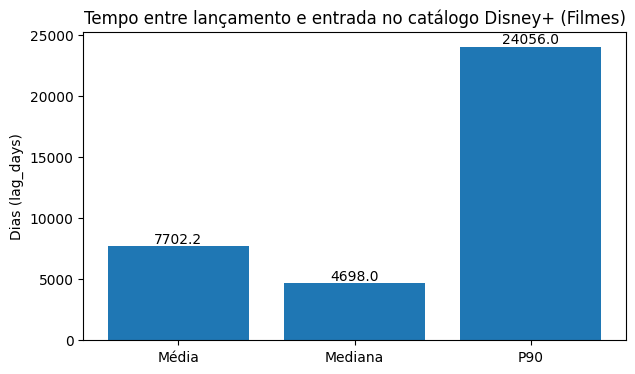

---------------------------------------------------------------------------
AssertionError                            Traceback (most recent call last)
File <command-8087695998810872>, line 14
     11 for i, v in enumerate(values):
     12     plt.text(i, v, f"{v:.1f}", ha="center", va="bottom")
---> 14 plt.ylim(0, max(values) * 1.15)
     15 plt.show()

File /databricks/python/lib/python3.12/site-packages/pyspark/sql/utils.py:308, in try_remote_functions.<locals>.wrapped(*args, **kwargs)
    305 if is_remote() and "PYSPARK_NO_NAMESPACE_SHARE" not in os.environ:
    306     from pyspark.sql.connect import functions
--> 308     return getattr(functions, f.__name__)(*args, **kwargs)
    309 else:
    310     return f(*args, **kwargs)

File /databricks/python/lib/python3.12/site-packages/pyspark/sql/connect/functions/builtin.py:1354, in max(col)
   1353 def max(col: "ColumnOrName") -> Column:
-> 1354     return _invoke_function_over_columns("max", col)

File /databricks/python/lib/python3

In [0]:
import matplotlib.pyplot as plt

labels = ["Média", "Mediana", "P90"]
values = [avg_days, median_days, p90_days]

plt.figure(figsize=(7, 4))
plt.bar(labels, values)
plt.ylabel("Dias (lag_days)")
plt.title("Tempo entre lançamento e entrada no catálogo Disney+ (Filmes)")

for i, v in enumerate(values):
    plt.text(i, v, f"{v:.1f}", ha="center", va="bottom")

plt.ylim(0, max(values) * 1.15)
plt.show()

In [0]:
import matplotlib.pyplot as plt

pdf = (
    df_metrics
    .select("lag_days")
    .sample(fraction=0.2, seed=42)   # amostra para performance
    .toPandas()
)

plt.figure(figsize=(9, 4))
plt.hist(pdf["lag_days"], bins=30)
plt.xlabel("lag_days (dias)")
plt.ylabel("Quantidade de títulos (amostra)")
plt.title("Distribuição do tempo entre lançamento e entrada no catálogo (Filmes)")

plt.axvline(avg_days, linestyle="--", linewidth=2, color="#B12228", label=f"Média ({avg_days:.1f})")
plt.axvline(median_days, linestyle="--", linewidth=2, color="#3DBB3D", label=f"Mediana ({median_days:.1f})")
plt.axvline(p90_days, linestyle="--", linewidth=2, color="#12194A", label=f"P90 ({p90_days:.1f})")

plt.legend()
plt.show()


In [0]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import numpy as np

# 1) Base: apenas filmes válidos
df_yearly = (
    spark.table("gold.fact_catalog_addition").alias("f")
    .join(spark.table("gold.dim_type").alias("t"), F.col("f.type_id") == F.col("t.type_id"), "inner")
    .where(
        (F.col("t.type_name") == "Movie") &
        F.col("f.full_date_added").isNotNull() &
        F.col("f.lag_days").isNotNull() &
        (F.col("f.lag_days") >= 0)
    )
    .withColumn("year_added", F.year(F.col("f.full_date_added")))
    .groupBy("year_added")
    .agg(
        F.avg("f.lag_days").alias("avg_lag_days"),
        F.count("*").alias("n_titles")
    )
    .orderBy("year_added")
)

# 2) Converter para pandas para plot
pdf = df_yearly.toPandas()

# (opcional) Filtrar anos com poucos títulos para evitar ruído (ajuste o limiar se quiser)
min_n = 30
pdf = pdf[pdf["n_titles"] >= min_n].copy()

# 3) Média móvel para suavizar
window = 3  # 3 anos
pdf["avg_lag_days_ma"] = pdf["avg_lag_days"].rolling(window=window, min_periods=1).mean()

# 4) Tendência linear (para evidência adicional)
x = pdf["year_added"].to_numpy(dtype=float)
y = pdf["avg_lag_days"].to_numpy(dtype=float)
slope, intercept = np.polyfit(x, y, 1)
trend = slope * x + intercept

# 5) Plot (não especifico cores)
plt.figure(figsize=(10, 4))
plt.plot(pdf["year_added"], pdf["avg_lag_days"], marker="o", label="Média anual de lag_days")
plt.plot(pdf["year_added"], pdf["avg_lag_days_ma"], linewidth=2, label=f"Média móvel ({window} anos)")
plt.plot(pdf["year_added"], trend, linestyle="--", linewidth=2, label=f"Tendência linear (inclinação: {slope:.1f} dias/ano)")

plt.xlabel("Ano de inclusão no catálogo (year_added)")
plt.ylabel("Tempo médio (lag_days) em dias")
plt.title("Evolução do tempo médio entre lançamento e inclusão no Disney+ (Filmes)")
plt.legend()
plt.grid(True, axis="y", linestyle="--", linewidth=0.5)
plt.show()


Entre 2019 e 2021, observamos uma redução significativa do tempo médio entre o lançamento dos filmes e sua inclusão no catálogo da Disney+, com uma queda média estimada de aproximadamente 3.292 dias por ano, conforme indicado pela inclinação negativa da tendência linear. Esse comportamento reflete a transição inicial de incorporação de catálogo legado para uma estratégia progressivamente mais orientada a lançamentos recentes e conteúdos próprios, reduzindo de forma consistente a defasagem temporal entre lançamento e disponibilização na plataforma.

### 6.2.2 Pergunta 2 - Como foi a evolução da diversidade de gêneros no catálogo ao longo do tempo (por ano de adição)?

Obervando apenas os gênereos isoladamente, observamos uma crescente de 39 para 41 gêneros distintos entre 2019 e 2021, contudo, isto poderia acontever apenas pela inclusão de novos títulos.  Para avaliar a real evolução da diversidade, foi criado um índice de diversidade relativa que neste caso é calculado considerando a razão entre os gênereos únicos adicionados por ano e a quantidade de títulos adicionados por ano. 

In [0]:
%sql
SELECT
  d.year AS year_added,
  COUNT(DISTINCT g.genre_id) AS unique_genres
FROM gold.fact_catalog_addition f
JOIN gold.dim_date d ON f.date_id = d.date_id
JOIN gold.bridge_title_genre btg ON f.title_id = btg.title_id
JOIN gold.dim_genre g ON btg.genre_id = g.genre_id
WHERE f.date_id IS NOT NULL
  AND d.year IS NOT NULL
GROUP BY d.year
ORDER BY d.year;

In [0]:
# Índice de Diversidade Relativa de Gêneros na Plataforma

from pyspark.sql import functions as F
import matplotlib.pyplot as plt

df_div_norm = (
    spark.table("gold.fact_catalog_addition").alias("f")
    .join(spark.table("gold.dim_date").alias("d"), F.col("f.date_id") == F.col("d.date_id"), "inner")
    .join(spark.table("gold.bridge_title_genre").alias("btg"), F.col("f.title_id") == F.col("btg.title_id"), "inner")
    .join(spark.table("gold.dim_genre").alias("g"), F.col("btg.genre_id") == F.col("g.genre_id"), "inner")
    .where(F.col("d.year").isNotNull())
    .groupBy(F.col("d.year").alias("year_added"))
    .agg(
        F.countDistinct(F.col("g.genre_id")).alias("unique_genres"),
        F.countDistinct(F.col("f.title_id")).alias("titles_added")
    )
    .withColumn(
        "diversity_ratio",
        F.col("unique_genres") / F.col("titles_added")
    )
    .orderBy("year_added")
)

pdf = df_div_norm.toPandas()

# Plot
plt.figure(figsize=(9, 4))
plt.plot(
    pdf["year_added"],
    pdf["diversity_ratio"],
    marker="o",
    linewidth=2
)

plt.xlabel("Ano de adição ao catálogo")
plt.ylabel("Diversidade relativa (gêneros únicos / títulos)")
plt.title("Mudança na diversidade dos títulos adicionados ao catálogo Disney+")
plt.grid(True, axis="y", linestyle="--", linewidth=0.5)

# Rótulos
for x, y in zip(pdf["year_added"], pdf["diversity_ratio"]):
    plt.text(x, y, f"{y:.2f}", ha="center", va="bottom")

plt.show()


In [0]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Base agregada por ano
df_yearly = (
    spark.table("gold.fact_catalog_addition").alias("f")
    .join(spark.table("gold.dim_date").alias("d"), F.col("f.date_id") == F.col("d.date_id"), "inner")
    .join(spark.table("gold.bridge_title_genre").alias("btg"), F.col("f.title_id") == F.col("btg.title_id"), "inner")
    .join(spark.table("gold.dim_genre").alias("g"), F.col("btg.genre_id") == F.col("g.genre_id"), "inner")
    .where(F.col("d.year").isNotNull())
    .groupBy(F.col("d.year").alias("year_added"))
    .agg(
        F.countDistinct(F.col("f.title_id")).alias("titles_added"),
        F.countDistinct(F.col("g.genre_id")).alias("unique_genres")
    )
    .withColumn(
        "diversity_ratio",
        F.col("unique_genres") / F.col("titles_added")
    )
    .orderBy("year_added")
)

pdf = df_yearly.toPandas()

fig, ax1 = plt.subplots(figsize=(10, 4))

# Eixo 1 – Volume de títulos
ax1.plot(
    pdf["year_added"],
    pdf["titles_added"],
    marker="o",
    label="Títulos adicionados"
)
ax1.set_xlabel("Ano de adição ao catálogo")
ax1.set_ylabel("Volume de títulos adicionados")

# Eixo 2 – Diversidade relativa
ax2 = ax1.twinx()
ax2.plot(
    pdf["year_added"],
    pdf["diversity_ratio"],
    marker="s",
    linestyle="--",
    label="Diversidade relativa (gêneros/título)"
)
ax2.set_ylabel("Diversidade relativa")

# Título
plt.title("Volume de títulos × Diversidade relativa por ano de adição")

# Legenda combinada
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="best")

plt.show()


Nestes dois últimos gráficos podemos observar que o índice vem aumentando ao longo do tempo, indicando que o crescimento do catálogo ocorreu acompanhado de maior diversidade de gêneros no conteúdo, particularmente a partir do segundo semestre de 2019, ampliando assim a variedade temática mesmo que o volume adicionado não seja tão grande.

### 6.2.3 Pergunta 3 - Quais são os 10 gêneros mais frequentes no catálogo do Disney+?

Na plataforma Disney+ podemos observar que há conteúdo com 44 gêneros distintos.  Estes gêneros variam quando observamos isoladamente por tipo de conteúdo, alguns prevalecem entre os filmes e há uma variação quando tratamos das séries.

Observamos que na visão global os 10 gêneros mais frequentes são Family, Animation, Comedy, Action-Adventure, Animals & Nature, Coming of Age, Fantasy, Documentary, Kids e Drama.

In [0]:
%sql
SELECT
  g.genre_name,
  COUNT(DISTINCT btg.title_id) AS titles_count
FROM gold.bridge_title_genre btg
JOIN gold.dim_genre g ON btg.genre_id = g.genre_id
GROUP BY g.genre_name
ORDER BY titles_count DESC, g.genre_name;


In [0]:
%sql
WITH genre_type_counts AS (
  -- Contagem distinta de títulos por gênero e tipo
  SELECT
    g.genre_name,
    t.type_name,
    COUNT(DISTINCT f.title_id) AS titles_count
  FROM gold.fact_catalog_addition f
  JOIN gold.dim_type t
    ON f.type_id = t.type_id
  JOIN gold.bridge_title_genre btg
    ON f.title_id = btg.title_id
  JOIN gold.dim_genre g
    ON btg.genre_id = g.genre_id
  GROUP BY g.genre_name, t.type_name
),

genre_totals AS (
  -- Total global por gênero (Movie + TV Show)
  SELECT
    genre_name,
    SUM(titles_count) AS total_titles
  FROM genre_type_counts
  GROUP BY genre_name
),

top10 AS (
  -- Top 10 global com rank determinístico (desempate por nome)
  SELECT
    genre_name,
    total_titles,
    ROW_NUMBER() OVER (ORDER BY total_titles DESC, genre_name ASC) AS rank_global
  FROM genre_totals
  QUALIFY rank_global <= 10
),

grouped AS (
  -- Agrupa em Top 10 (mantém nome) e soma o resto em "Outros"
  SELECT
    CASE
      WHEN gt.genre_name IN (SELECT genre_name FROM top10) THEN gt.genre_name
      ELSE 'Outros'
    END AS genre_group,
    gt.type_name,
    SUM(gt.titles_count) AS titles_count
  FROM genre_type_counts gt
  GROUP BY
    CASE
      WHEN gt.genre_name IN (SELECT genre_name FROM top10) THEN gt.genre_name
      ELSE 'Outros'
    END,
    gt.type_name
),

pivoted AS (
  -- "Pivot" manual para colunas Movie/TV Show (como no empilhado)
  SELECT
    genre_group,
    COALESCE(SUM(CASE WHEN type_name = 'Movie'   THEN titles_count END), 0) AS movies_count,
    COALESCE(SUM(CASE WHEN type_name = 'TV Show' THEN titles_count END), 0) AS tvshows_count,
    COALESCE(SUM(titles_count), 0)                                         AS total_count
  FROM grouped
  GROUP BY genre_group
)

SELECT
  p.genre_group,
  p.movies_count,
  p.tvshows_count,
  p.total_count
FROM pivoted p
LEFT JOIN top10 t
  ON p.genre_group = t.genre_name
ORDER BY
  CASE WHEN p.genre_group = 'Outros' THEN 999 ELSE t.rank_global END;

In [0]:
#Gráfico para visualização dos Top 10 gêneros na plataforma - independente de tipo de conteúdo
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# 1) Frequência de títulos por gênero (Gold)
df_genre_counts = (
    spark.table("gold.bridge_title_genre").alias("btg")
    .join(
        spark.table("gold.dim_genre").alias("g"),
        F.col("btg.genre_id") == F.col("g.genre_id"),
        "inner"
    )
    .groupBy(F.col("g.genre_name").alias("genre_name"))
    .agg(F.countDistinct(F.col("btg.title_id")).alias("titles_count"))
    .orderBy(F.col("titles_count").desc(), F.col("genre_name").asc())
)

# 2) Top 10 gêneros
top_n = 10
pdf_top = df_genre_counts.limit(top_n).toPandas()

# 3) Soma do restante ("Outros")
others_count = (
    df_genre_counts
    .subtract(df_genre_counts.limit(top_n))
    .agg(F.sum("titles_count").alias("others_count"))
    .collect()[0]["others_count"]
)

# 4) DataFrame final para o gráfico
labels = list(pdf_top["genre_name"]) + ["Outros"]
values = list(pdf_top["titles_count"]) + [others_count]

# 5) Plot (barras horizontais)
plt.figure(figsize=(10, 6))
plt.barh(labels[::-1], values[::-1])
plt.xlabel("Quantidade de títulos")
plt.ylabel("Gênero")
plt.title("Distribuição dos gêneros no catálogo Disney+ (Top 10 + Outros)")
plt.grid(True, axis="x", linestyle="--", linewidth=0.5)

# Rótulos
for i, v in enumerate(values[::-1]):
    plt.text(v, i, f" {int(v)}", va="center")

plt.show()


In [0]:
#Gráfico com os gêneros classificados pelos tipos de conteúdo
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import numpy as np

# 1) Frequência por gênero e tipo
df_genre_type = (
    spark.table("gold.fact_catalog_addition").alias("f")
    .join(spark.table("gold.dim_type").alias("t"), F.col("f.type_id") == F.col("t.type_id"), "inner")
    .join(spark.table("gold.bridge_title_genre").alias("btg"), F.col("f.title_id") == F.col("btg.title_id"), "inner")
    .join(spark.table("gold.dim_genre").alias("g"), F.col("btg.genre_id") == F.col("g.genre_id"), "inner")
    .groupBy(
        F.col("g.genre_name").alias("genre_name"),
        F.col("t.type_name").alias("type_name")
    )
    .agg(F.countDistinct(F.col("f.title_id")).alias("titles_count"))
)

# 2) Top 10 gêneros no geral
top_n = 10
top_genres = (
    df_genre_type
    .groupBy("genre_name")
    .agg(F.sum("titles_count").alias("total_titles"))
    .orderBy(F.col("total_titles").desc())
    .limit(top_n)
    .select("genre_name")
)

top_genres_list = [r["genre_name"] for r in top_genres.collect()]

# 3) Agrupar demais como "Outros"
df_grouped = (
    df_genre_type
    .withColumn(
        "genre_group",
        F.when(F.col("genre_name").isin(top_genres_list), F.col("genre_name"))
         .otherwise(F.lit("Outros"))
    )
    .groupBy("genre_group", "type_name")
    .agg(F.sum("titles_count").alias("titles_count"))
)

pdf = df_grouped.toPandas()

# 4) Preparar dados para o gráfico empilhado
genres = top_genres_list + ["Outros"]

movie_counts = []
tv_counts = []

for g in genres:
    movie_counts.append(
        pdf[(pdf["genre_group"] == g) & (pdf["type_name"] == "Movie")]["titles_count"].sum()
    )
    tv_counts.append(
        pdf[(pdf["genre_group"] == g) & (pdf["type_name"] == "TV Show")]["titles_count"].sum()
    )

movie_counts = np.array(movie_counts)
tv_counts = np.array(tv_counts)

# 5) Plot – barras empilhadas horizontais
plt.figure(figsize=(11, 6))

plt.barh(genres, movie_counts, label="Filmes")
plt.barh(genres, tv_counts, left=movie_counts, label="Séries")

plt.xlabel("Quantidade de títulos")
plt.ylabel("Gênero")
plt.title("Distribuição de gêneros no catálogo Disney+ — Filmes × Séries (Top 10 + Outros)")
plt.legend()
plt.grid(True, axis="x", linestyle="--", linewidth=0.5)

# Rótulos opcionais (total por gênero)
for i, total in enumerate(movie_counts + tv_counts):
    plt.text(total, i, f" {int(total)}", va="center")

plt.show()


# 7. Autoavaliação

O desenvolvimento deste trabalho permitiu atingir de forma satisfatória os objetivos propostos, especialmente no que se refere à construção de um pipeline de dados completo em ambiente Databricks, desde a ingestão de dados brutos até a disponibilização de informações analíticas estruturadas. A aplicação da arquitetura Medallion possibilitou organizar o processo de ETL de maneira clara e modular, enquanto a modelagem dimensional em esquema estrela na camada Gold viabilizou análises consistentes sobre o catálogo da Disney+, respondendo às perguntas centrais do estudo relacionadas ao tempo de entrada dos títulos na plataforma, à evolução da diversidade de gêneros e à distribuição temática do catálogo.

Entre as principais dificuldades encontradas, destaca-se a limitação da granularidade dos dados de origem, em especial a ausência de informações completas de data de lançamento, o que exigiu a adoção de premissas metodológicas para o cálculo do intervalo entre lançamento e entrada no catálogo. Adicionalmente, o tratamento de campos multivalorados, como os gêneros, demandou atenção especial na etapa de normalização e na definição correta de relacionamentos, de modo a evitar duplicidades e distorções nas análises agregadas. Outro desafio relevante foi garantir a consistência entre a modelagem conceitual (DER), a implementação física das tabelas e as consultas analíticas, exigindo validações contínuas ao longo do desenvolvimento.

Como oportunidades futuras de evolução, o estudo pode ser enriquecido com a incorporação de novas fontes de dados, como informações detalhadas sobre datas de lançamento, popularidade dos títulos ou métricas de audiência, permitindo análises mais precisas e aprofundadas. Além disso, a implementação de verificações automatizadas de qualidade de dados, o uso de tabelas agregadas para consumo e a aplicação de técnicas estatísticas mais robustas para análise de tendências representam caminhos naturais para ampliar a maturidade do MVP. Essas extensões reforçariam tanto o valor analítico quanto a aderência do projeto a cenários reais de engenharia de dados em ambientes Lakehouse.

